In [3]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import time
import scienceplots
import torchsummary

import dataset
import data_Preprocess 
import models
import uLoss
import Metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ('device = ',device)
seed = 123 #seed必须是int，可以自行设置
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
plt.style.use('science')
plt.rcParams['text.usetex'] = False

param = {
    'mesh_size':[0.1,0.1],
    'structure_size':[10,10],
    'measurements_num':7,
    'device':device,
    'is_plotInputMap':False,
    'Lambda':0.0,
    'HS_region':torch.tensor(([[[1.5,2.5],[6.9,8.4]],# region_1
                               [[4.4,8.4],[7.2,8.0]],# region_2
                               [[0.6,1.6],[5.0,6.0]],# region_3(1)
                               [[0.6,3.1],[4.0,5.0]],# region_3(2)
                               [[1.0,4.0],[0.8,2.8]],# region_4
                               [[5.6,8.6],[1.3,4.9]]])),# region_5
    'BCs':['Neumann','Convection','Radiation','Radiation'],# top,bottom,left,right
    'Heat Transfer Rate':52,
    'Convective coe':10,
    'Emissivity':0.05,
    'q':15,
    'T_a':20,
    'BC_regular':True,
    'HS_regular':False,
    'Direchlet BC':20,
    'learning_rate': 0.02,
    'epochs': 20000,
    'dis_interval': 1000,
    'is_plotLoss':True,
    'is_plotResult':False,
    'layout':'_random'
    
}

device =  cuda:0


# vary h

In [4]:
train_set = dataset.MyDataset('Train','Co-driven',param)
test_set = dataset.MyDataset('Varyh','Co-driven',param)
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                          batch_size = 32,
                                          shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                          batch_size = 11,
                                          shuffle = False)
Trues = data_Preprocess.get_Tfields('Test').unsqueeze(1)
trues = Trues[38][0]
Unet=torch.load('Layout-7.pt')
for idx,data in enumerate(test_loader):
    MP = data[0].clone().detach().requires_grad_(True)
    HSD = data[1].clone().detach().requires_grad_(True)
    break
out = Unet(MP.unsqueeze(1))
out = uLoss.Fill_withMeasurements(out,MP,param)

In [8]:
out.size()

torch.Size([11, 1, 101, 101])

In [5]:
def NMAE(T_pred,T_true):
    maxs,indice=torch.max(torch.abs(T_true.squeeze(1).cpu()).flatten(1,-1),1)
    return torch.mean(torch.abs(T_true.cpu()-T_pred.cpu())/maxs.unsqueeze(-1).unsqueeze(-1))

def RMSE(T_pred,T_true):
    return torch.sqrt(torch.mean((T_true.cpu()-T_pred.cpu())**2))
test_set = dataset.MyDataset('Varyh','Co-driven',param)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                          batch_size = 11,
                                          shuffle = False)
for idx,data in enumerate(test_loader):
    MP = data[0].clone().detach().requires_grad_(True)
    HSD = data[1].clone().detach().requires_grad_(True)
    break
out = Unet(MP.unsqueeze(1))
out = uLoss.Fill_withMeasurements(out,MP,param)
H_coe = [9.5,9.6,9.7,9.8,9.9,10.0,10.1,10.2,10.3,10.4,10.5]
NMAEs_varyh = []
for i in range(out.size(0)):
    print ('h={}'.format(H_coe[i]))
    print (NMAE(out[i][0],trues).cpu().detach())
    NMAEs_varyh.append((NMAE(out[i][0],trues).cpu().detach())*100)

test_set = dataset.MyDataset('Varymu','Co-driven',param)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                          batch_size = 11,
                                          shuffle = False)
for idx,data in enumerate(test_loader):
    MP = data[0].clone().detach().requires_grad_(True)
    HSD = data[1].clone().detach().requires_grad_(True)
    break
out = Unet(MP.unsqueeze(1))
out = uLoss.Fill_withMeasurements(out,MP,param)
MU_coe = [0.0475,0.0480,0.0485,0.0490,0.0495,0.050,0.0505,0.0510,0.0515,0.0520,0.0525]
NMAEs_varymu = []
for i in range(out.size(0)):
    print ('mu={}'.format(MU_coe[i]))
    print (NMAE(out[i][0],trues).cpu().detach())
    NMAEs_varymu.append((NMAE(out[i][0],trues).cpu().detach())*100)

torch.save(NMAEs_varymu,'NMAEs_Varymu.pt')
torch.save(NMAEs_varyh,'NMAEs_Varyh.pt')

h=9.5
tensor(0.0072)
h=9.6
tensor(0.0072)
h=9.7
tensor(0.0071)
h=9.8
tensor(0.0071)
h=9.9
tensor(0.0071)
h=10.0
tensor(0.0071)
h=10.1
tensor(0.0070)
h=10.2
tensor(0.0069)
h=10.3
tensor(0.0069)
h=10.4
tensor(0.0069)
h=10.5
tensor(0.0069)
mu=0.0475
tensor(0.0071)
mu=0.048
tensor(0.0071)
mu=0.0485
tensor(0.0071)
mu=0.049
tensor(0.0070)
mu=0.0495
tensor(0.0070)
mu=0.05
tensor(0.0071)
mu=0.0505
tensor(0.0071)
mu=0.051
tensor(0.0070)
mu=0.0515
tensor(0.0070)
mu=0.052
tensor(0.0070)
mu=0.0525
tensor(0.0070)


In [6]:
print ((NMAEs_varyh[10]-NMAEs_varyh[5])/NMAEs_varyh[5]*100)
print ((NMAEs_varymu[7]-NMAEs_varymu[5])/NMAEs_varymu[5]*100)

tensor(-1.5959)
tensor(-0.7722)


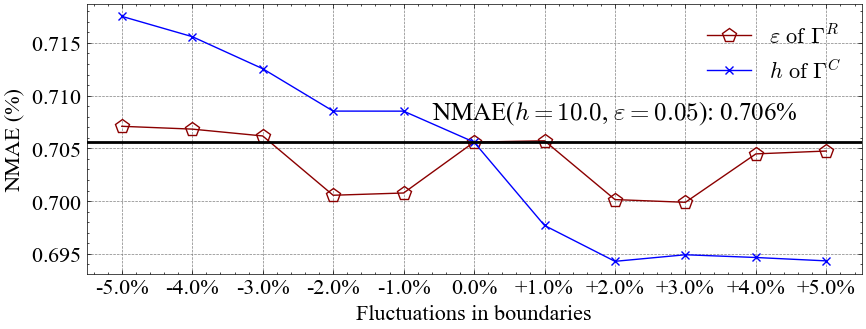

In [11]:
plt.figure(figsize=(10,3.5))

plt.rcParams.update({'font.size': 16, 'font.family': 'serif', 'font.serif': ['Times New Roman']})
# 绘制第一条折线图
plt.plot(NMAEs_varymu, color='darkred', marker='p', label=r'$\varepsilon \ \mathrm{of} \ \Gamma^R$', markersize=10, markerfacecolor='none')

# 绘制第二条折线图
plt.plot(NMAEs_varyh, color='blue', marker='x', label=r'$h \ \mathrm{of} \ \Gamma^C$')
plt.axhline(y=NMAEs_varymu[5], color='black', linewidth=2)
plt.text(7, 0.707, r'NMAE($h=10.0$, $\varepsilon=0.05$): 0.706%', ha='center', va='bottom', fontsize=18, color='black')
Names = ['-5.0%','-4.0%','-3.0%','-2.0%','-1.0%','0.0%','+1.0%','+2.0%','+3.0%','+4.0%','+5.0%']
# 添加标题和标签
plt.xlabel('Fluctuations in boundaries')  # 设置横坐标标签
plt.ylabel('NMAE (%)')  # 设置纵坐标标签
plt.xticks(range(0, len(Names)), Names)
#plt.ylim(0,None)
#plt.xlim(0,10)
# 显示图例
plt.grid(True, linestyle='--', color='gray', linewidth=0.5)
plt.legend()

# 显示图形
plt.show()

In [ ]:
def NMAE(T_pred,T_true):
    maxs,indice=torch.max(torch.abs(T_true.squeeze(1).cpu()).flatten(1,-1),1)
    print (maxs.unsqueeze(-1).unsqueeze(-1).size())
    return torch.mean(torch.abs(T_true.cpu()-T_pred.cpu())/maxs.unsqueeze(-1).unsqueeze(-1))

def RMSE(T_pred,T_true):
    return torch.sqrt(torch.mean((T_true.cpu()-T_pred.cpu())**2))

print (NMAE(out[label][0],trues[label][0]))
print (RMSE(out[label][0],trues[label][0]))
label=38

plt.figure(figsize=(4,4))
plt.imshow(trues[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.title('True for sample-38 ($^\circ$C)')
plt.colorbar()

plt.figure(figsize=(4,4))
plt.imshow(out[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Prediction for sample-38 ($^\circ$C)')

plt.figure(figsize=(4,4))
plt.imshow((trues[label][0]-out[label][0].cpu()).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('err$_{abs}$ ($^\circ$C)')
plt.show()

plt.figure(figsize=(4,4))
plt.imshow(torch.abs(((trues[label][0]-out[label][0].cpu())/trues[label][0])*100).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('err$_{relative}$ (%)')
plt.show()